# Not Hotdog ... In Production with Tensorflow and Tensorflow Extended (TFX)

Exploring machine learning deployment with tensorflow and the 'not hotdog' use case from HBO's Sillicon Valley.

![not hotdog](./NotHotdog.jpg)

# Table of Contents
1. [Introduction](#intro)
2. [Part I - Proof of Concept](#poc)
3. [Part II - Model Encapsulation](#part2)

# Introduction <a id="intro"></a>
A lot of machine learning tutorials foucus on training & evaluating ML models.  Not many discuss challenges and best practices around running ML models in production.  In this notebook we focus on features of tensorflow and tensorflow extended that help with ML model deployment. 

# Part I - Proof of Concept <a id="poc"></a>

Let's start with the simplest possible 'not hotdog' service.  

We will:
1. download a pre-trained model from [tfhub]
2. test it with a few images
3. export it to tensorflow's SavedModel format 
4. serve the model using tensorflow serving  

We loosely follow [this example] provided in tensorflow serving.

[tfhub]: https://www.tensorflow.org/hub
[this example]: https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/tutorials/Serving_REST_simple.ipynb

In [1]:
# if any of these imports fail see the README install instructions using Docker
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import PIL.Image as Image
import tempfile
import os
import json
import requests
import matplotlib.pylab as plt

In [2]:
# constants
IMAGE_SHAPE = (224, 224)
MODEL_DIR = tempfile.gettempdir()

In [3]:
# download an imagenet classifier from tfhub
model_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
model_part_1 = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
# download model catagories so we can understand what the model is saying
catagories_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
catagories = np.array(open(catagories_path).read().splitlines())
print(catagories)

16384/10484 [==============================================] - 0s 0us/step
['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue']


188416/180431 [===============================] - 0s 0us/step


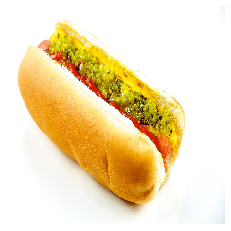

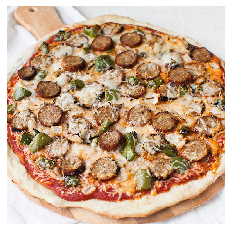

In [5]:
# download some test images (we don't care about model performance here so we only need a few)
def getImage(fn, url):
    imgpath = tf.keras.utils.get_file(fn, url)
    return np.array(Image.open(imgpath).resize(IMAGE_SHAPE))/255.0

def showImage(img, catagory=None, score=None):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if catagory:
        _ = plt.title("Prediction: {} ({})".format(catagory,score))
    return None
    
hotdog_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Hotdog_-_Evan_Swigart.jpg/1600px-Hotdog_-_Evan_Swigart.jpg'
not_hotdog_url = 'https://d1doqjmisr497k.cloudfront.net/-/media/mccormick-us/recipes/grill-mates/s/800/sausage-and-pepper-pizza.jpg'
hotdog = getImage('hotdog.jpg', hotdog_url)
not_hotdog = getImage('not_hotdog.jpg', not_hotdog_url)
showImage(hotdog)
showImage(not_hotdog)

In [6]:
# stack images into an array of test images
test_images = np.vstack((hotdog[np.newaxis, ...],not_hotdog[np.newaxis, ...]))
test_images.shape

(2, 224, 224, 3)

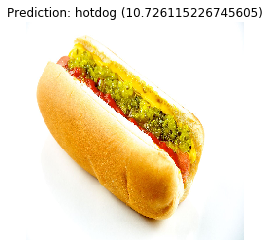

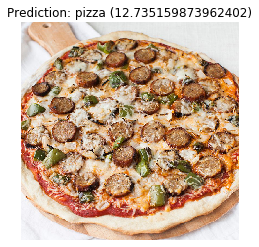

In [7]:
# test the model
result = model_part_1.predict(test_images[0:])
pred_idx = np.argmax(result[0], axis=-1)
score = result[0,pred_idx]
pred_catagory = catagories[pred_idx]
showImage(test_images[0], pred_catagory, score)

result = model_part_1.predict(test_images[1:])
pred_idx = np.argmax(result[0], axis=-1)
score = result[0,pred_idx]
pred_catagory = catagories[pred_idx]
showImage(test_images[1], pred_catagory, score)

In [8]:
# Export the model using tensorflow 'SavedModel' format (save_format = 'tf')
def exportModel(model, model_dir, version=1):
    export_path = os.path.join(model_dir, str(version))
    model.save(export_path, overwrite=True, include_optimizer=False, save_format='tf')
    return export_path
    
export_path = exportModel(model_part_1, MODEL_DIR, version=1)
print('\nSaved model:')
print(export_path)
!ls -l {export_path}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
/tmp/1
total 1372
drwxr-xr-x 1 root root       0 Nov 24 06:39 assets
-rw-r--r-- 1 root root 1401896 Nov 24 06:39 saved_model.pb
drwxr-xr-x 1 root root      88 Nov 24 06:39 variables


In [9]:
# inspect the saved model with the 'saved_model_cli'
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['keras_layer'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1001)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


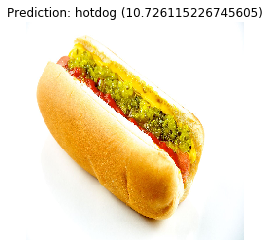

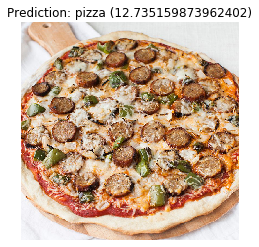

In [10]:
# load the model into memory and confirm it still works
model_part_1 = tf.keras.models.load_model(export_path)

# hotdog test
result = model_part_1.predict(test_images[0:])
pred_idx = np.argmax(result[0], axis=-1)
score = result[0,pred_idx]
pred_catagory = catagories[pred_idx]
showImage(test_images[0], pred_catagory, score)

# not hotdog test
result = model_part_1.predict(test_images[1:])
pred_idx = np.argmax(result[0], axis=-1)
score = result[0,pred_idx]
pred_catagory = catagories[pred_idx]
showImage(test_images[1], pred_catagory, score)

Start Tensorflow Serving listening for requests on port 8501

In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=nothotdog \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [13]:
!tail server.log

2019-11-24 06:39:46.335897: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-24 06:39:46.471302: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-11-24 06:39:47.070098: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /tmp/1
2019-11-24 06:39:47.206094: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 1037468 microseconds.
2019-11-24 06:39:47.212204: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2019-11-24 06:39:47.217664: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: nothotdog version: 1}
2019-11-24 06:39:47.220278: I 

In [14]:
# add test images to json object and send as request to tensorflow serving
data = json.dumps({"signature_name": "serving_default", "instances": test_images.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/nothotdog/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

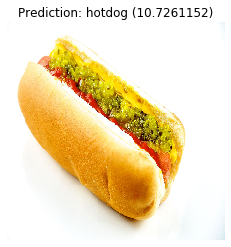

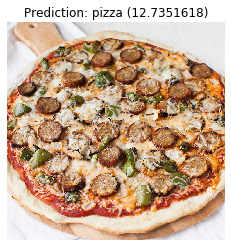

In [15]:
# check the predictions from tensorflow serving
for idx, pred in enumerate(predictions):
    pred_idx = np.argmax(pred, axis=-1)
    score = pred[pred_idx]
    pred_catagory = catagories[pred_idx]
    showImage(test_images[idx], pred_catagory, score)

It works!  But there's a problem...

Our 'hotdog' detetor is returning 'pizza' instead of 'not hotdog'.

It's actually even worse than that.  The model is returning an array of numbers instead of strings.  There is no 'hotdog', no 'pizza', and certaintly no 'not hotdog' in the output from tensorflow serving.  To print the catagories 'hotdog' and 'pizza' we had to execute additional python code outside of tensorflow serving to interpret the output.  

In part II we will fix these problems to get our hotdog / not hotdog detector out of POC mode and into production.

# Part II - Model Encapsulation <a id="part2"></a>

The model from [Part I](#poc) expects the client to interpret the output.  This could cause problems in production.  For example, clients would need to download the list of categories used by the model and keep it up-to-date.  Clients would also need to implement a decision criteria for outputting 'hotdog' and 'not hotdog'.  We used an 'argmax' decision criteria above, but there are other strategies that might work better depending on the use case.    

Where should model dependencies and decision logic be implemented in production?  In general, the model developers should take responsibility for the end-to-end model performance.  Therefore, anything that could have a direct effect on model performance, should be integrated directly into the exported model.  

In this part we add post processing operations to the exported model, so that tensorflow serving is able to return the exact decision we want to take ('hotdog' or 'not hotdog'), instead of a raw list of probabilities.

In [16]:
# define a custom keras layer that maps neural network output probabilities 
# to 'hotdog' and 'not hotdog' categories
class OutputLayerCategory(layers.Layer):
    def __init__(self, labels, **kwargs):
        # store the imagenet labels needed to interpret the catagories
        super(OutputLayerCategory, self).__init__(**kwargs)
        self.labels = labels
    
    def call(self, inputs):
        # get hotdog category using argmax decision criteria
        # must use only tensorflow ops if used with tensorflow serving
        cat_idx = tf.math.argmax(input=inputs, axis=1)
        res = tf.gather(tf.constant(self.labels), cat_idx)
        cat = tf.where(tf.math.equal(res, 'hotdog'), 
                       tf.constant('hotdog'), 
                       tf.constant('not hotdog'), 
                       name='cat')
        return cat
    
    def get_config(self):
        # needed for model serialization
        config = super(OutputLayerCategory, self).get_config()
        config.update({'labels': self.labels})
        return config
    
    def compute_output_shape(self,inputShape):
        return (inputShape[0],1)

In [17]:
# add the new output layer to the model from Part I (uses the Keras functional API)
inputs = tf.keras.Input(shape=IMAGE_SHAPE+(3,), name='input')
model = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
cat_layer = OutputLayerCategory(catagories, name='catagory')
x = model(inputs)
out_cat = cat_layer(x)
model_part_2 = tf.keras.Model(inputs=inputs,outputs=[out_cat])

In [18]:
# export the model
export_path = exportModel(model_part_2, MODEL_DIR, version=2)
print('\nSaved model:')
print(export_path)
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/2/assets


INFO:tensorflow:Assets written to: /tmp/2/assets



Saved model:
/tmp/2
total 1480
drwxr-xr-x 1 root root       0 Nov 24 06:40 assets
-rw-r--r-- 1 root root 1514966 Nov 24 06:40 saved_model.pb
drwxr-xr-x 1 root root      88 Nov 24 06:40 variables


In [19]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['catagory'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [20]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/nothotdog/versions/2:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

In [21]:
predictions

['hotdog', 'not hotdog']

In [22]:
# define a custom keras layer that selects the neural network output probability
# for the hotdog catagory
class OutputLayerScore(layers.Layer):
    def __init__(self, labels, **kwargs):
        super(OutputLayerScore, self).__init__(**kwargs)
        self.labels = labels
    
    def call(self, inputs):
        #get hotdog score
        score_idx = tf.where(tf.math.equal(tf.constant(self.labels), 'hotdog'))
        score = inputs[:,score_idx[0][0]]
        return score
    
    def get_config(self):
        config = super(OutputLayerScore, self).get_config()
        config.update({'labels': self.labels})
        return config
    
    def compute_output_shape(self,inputShape):
        return (inputShape[0],1)

In [23]:
# add the new output layer to the model from Part I (uses the Keras functional API)
score_layer = OutputLayerScore(catagories, name='score')
out_score = score_layer(x)
model_part_2 = tf.keras.Model(inputs=inputs,outputs=[out_cat, out_score])

In [24]:
# export the model
export_path = exportModel(model_part_2, MODEL_DIR, version=3)
print('\nSaved model:')
print(export_path)
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/3/assets


INFO:tensorflow:Assets written to: /tmp/3/assets



Saved model:
/tmp/3
total 1600
drwxr-xr-x 1 root root       0 Nov 24 06:40 assets
-rw-r--r-- 1 root root 1635103 Nov 24 06:40 saved_model.pb
drwxr-xr-x 1 root root      88 Nov 24 06:40 variables


In [25]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['catagory'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: StatefulPartitionedCall:0
    outputs['score'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: StatefulPartitionedCall:1
  Method name is: tensorflow/serving/predict


In [26]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/nothotdog/versions/3:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

In [27]:
predictions

[{'catagory': 'hotdog', 'score': 10.7261152},
 {'catagory': 'not hotdog', 'score': 3.27019691}]

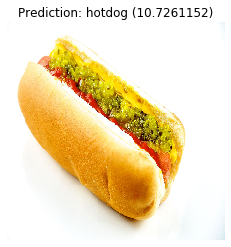

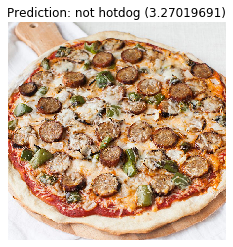

In [28]:
for idx, pred in enumerate(predictions):
    plt.figure()
    plt.imshow(test_images[idx])
    plt.axis('off')
    _ = plt.title("Prediction: {} ({})".format(pred['catagory'],pred['score']))

# Part III - Remote Ops